##### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
##using the data by mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colb Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
0


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## to resize images from train dataset to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## to resize images from validation dataset to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


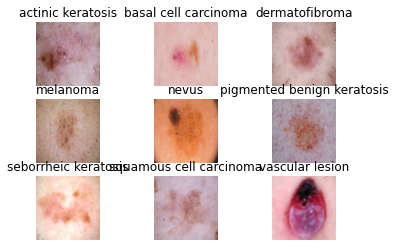

In [9]:
import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:


num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

In [12]:
###choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 794s 1s/step - loss: 1.9458 - accuracy: 0.2650 - val_loss: 1.7590 - val_accuracy: 0.3267
Epoch 2/20
169/169 [==============================] - 4s 23ms/step - loss: 1.4385 - accuracy: 0.4564 - val_loss: 1.3372 - val_accuracy: 0.4707
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 1.2023 - accuracy: 0.5449 - val_loss: 1.2342 - val_accuracy: 0.5130
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 1.0209 - accuracy: 0.6293 - val_loss: 1.0363 - val_accuracy: 0.6244
Epoch 5/20
169/169 [==============================] - 4s 23ms/step - loss: 0.8611 - accuracy: 0.6920 - val_loss: 0.9942 - val_accuracy: 0.6511
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 0.6605 - accuracy: 0.7609 - val_loss: 0.8337 - val_accuracy: 0.7231
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 0.5359 - accuracy: 0.8056 - val_loss: 0.8000 - val_accuracy: 0.7468

### Visualizing training results

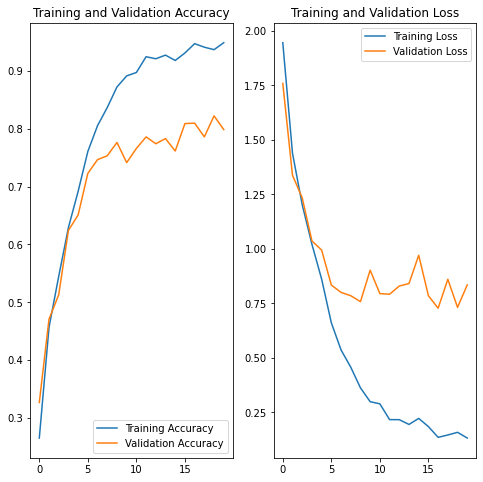

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



The model clearly overfits.
* The training accuracy is skyrocketing while the validation accuracy is around 50%. 

* The loss on training set decreases after each epoch but in case of the validation set it climbs back again after the 5th epoch. 

The model memorized the data instead of generalizing and learning real features and general relationships

In [16]:
#choosing an appropriate data augumentation strategy. 


with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ])

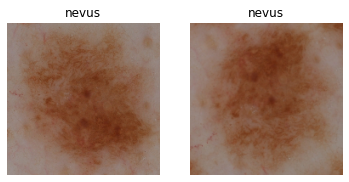

In [17]:
#visualize the augmentation strategy works for one instance of training image

for image, label in train_ds.take(1):
        ax = plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
        
        augmented = data_augmentation(image)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')


### Creating the model, compile and train the model


In [18]:

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])


### Compiling the model

In [19]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 10s 52ms/step - loss: 2.0396 - accuracy: 0.2357 - val_loss: 1.6634 - val_accuracy: 0.3660
Epoch 2/20
169/169 [==============================] - 9s 51ms/step - loss: 1.6020 - accuracy: 0.3908 - val_loss: 1.4739 - val_accuracy: 0.4195
Epoch 3/20
169/169 [==============================] - 9s 51ms/step - loss: 1.4929 - accuracy: 0.4312 - val_loss: 1.3712 - val_accuracy: 0.4640
Epoch 4/20
169/169 [==============================] - 9s 51ms/step - loss: 1.3916 - accuracy: 0.4683 - val_loss: 1.2986 - val_accuracy: 0.4796
Epoch 5/20
169/169 [==============================] - 9s 51ms/step - loss: 1.3493 - accuracy: 0.4779 - val_loss: 1.3181 - val_accuracy: 0.4684
Epoch 6/20
169/169 [==============================] - 9s 51ms/step - loss: 1.3071 - accuracy: 0.4913 - val_loss: 1.4128 - val_accuracy: 0.4959
Epoch 7/20
169/169 [==============================] - 9s 50ms/step - loss: 1.2665 - accuracy: 0.5095 - val_loss: 1.1996 - val_accuracy: 0.542

### Visualizing the results

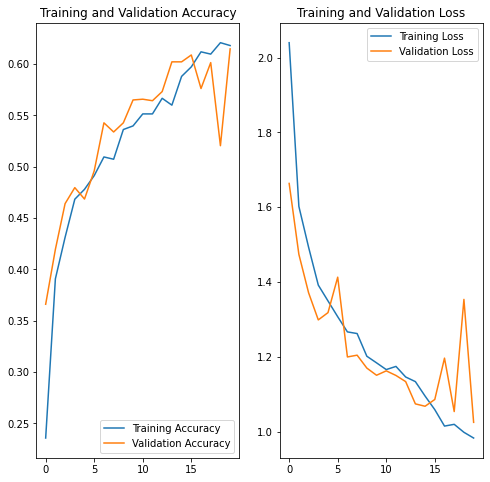

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* The application of data augmentation and dropout layer clearly reduced the overfitting
* Results on training and validation datasets are closer signalizing that the model - instead of memorizing the dataset - managed to generalize well.
* The overall accuracy is not that high and still there is a significant difference between the training and validation accuracy 

<BarContainer object of 9 artists>

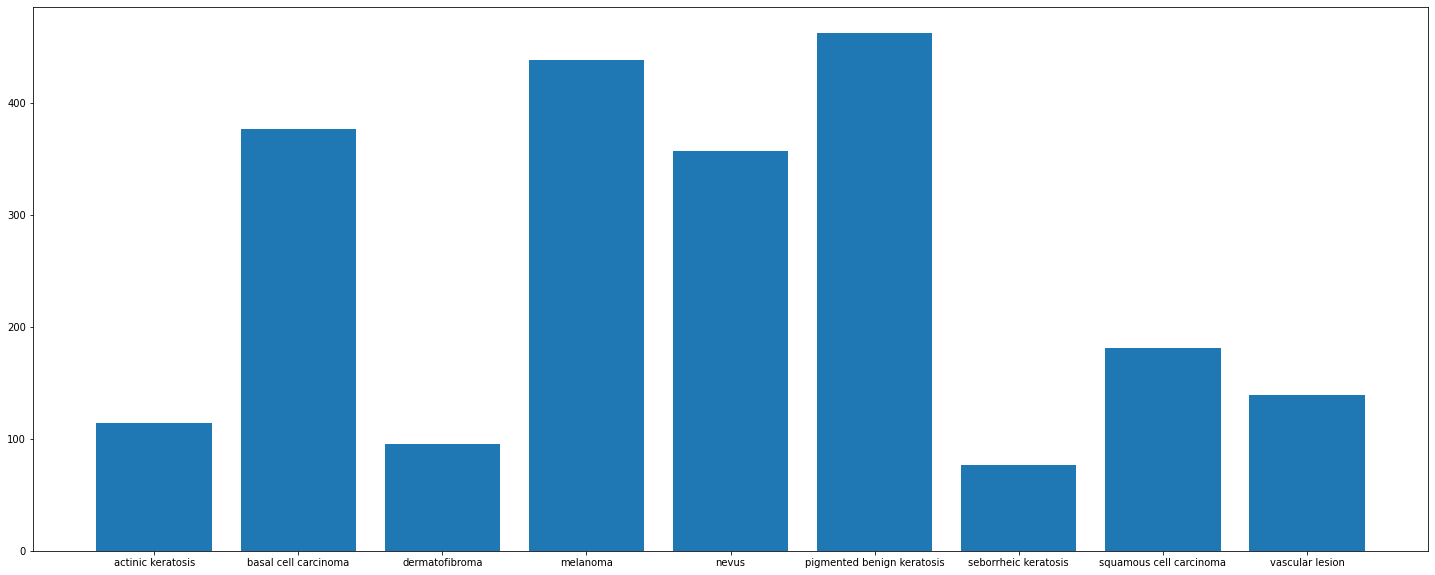

In [22]:

class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### - Which class has the least number of samples?
* seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
* pigmented benign
* melanoma
* basal cell carcinoma 
* nevus

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
path_to_training_dataset='/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB63A254DC0>: 100%|██████████| 500/500 [00:21<00:00, 23.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB63A2CD100>: 100%|██████████| 500/500 [00:22<00:00, 21.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB63DEF97C0>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB63A223BB0>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB63A317070>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB63A28DA00>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB63A28C9D0>: 100%|██████████| 500/500 [00:41<00:00, 12.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB63A2264C0>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB6521FD460>: 100%|██████████| 500/500 [00:17<00:00, 27.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_401417a7-bb4e-4d24-b4c4-8ec694488370.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_153cec71-dd28-42d8-b946-d0c8ead0767f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_f8e62213-252c-45a0-a4cc-f0a848e9c8c0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_55240996-af08-496f-a8cf-0065f597a643.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [30]:
df2['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
vascular lesion               1000
nevus                         1000
squamous cell carcinoma       1000
seborrheic keratosis          1000
pigmented benign keratosis    1000
melanoma                      1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [32]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


####  Creating a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [34]:

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

In [35]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
epochs = 50
## training the model using 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 64s 216ms/step - loss: 1.7516 - accuracy: 0.3274 - val_loss: 1.4191 - val_accuracy: 0.4366
Epoch 2/50
281/281 [==============================] - 57s 200ms/step - loss: 1.3968 - accuracy: 0.4500 - val_loss: 1.2851 - val_accuracy: 0.4931
Epoch 3/50
281/281 [==============================] - 54s 189ms/step - loss: 1.3245 - accuracy: 0.4845 - val_loss: 1.2547 - val_accuracy: 0.5024
Epoch 4/50
281/281 [==============================] - 54s 188ms/step - loss: 1.2700 - accuracy: 0.4976 - val_loss: 1.3969 - val_accuracy: 0.4784
Epoch 5/50
281/281 [==============================] - 54s 189ms/step - loss: 1.2236 - accuracy: 0.5231 - val_loss: 1.1804 - val_accuracy: 0.5523
Epoch 6/50
281/281 [==============================] - 53s 187ms/step - loss: 1.1447 - accuracy: 0.5516 - val_loss: 1.0921 - val_accuracy: 0.5919
Epoch 7/50
281/281 [==============================] - 54s 189ms/step - loss: 1.0980 - accuracy: 0.5706 - val_loss: 1.1177 - val_ac

####  Visualize the model results

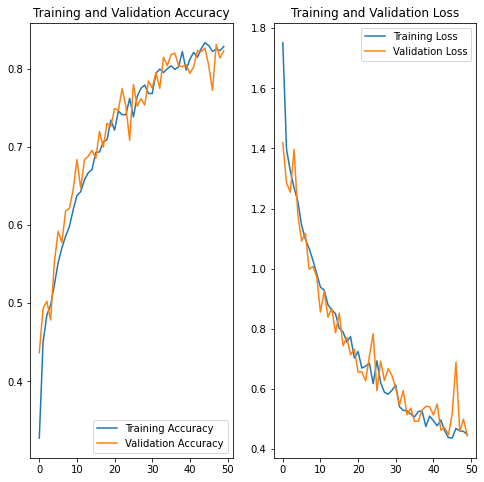

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* Class rebalance helped us to get rid of the overfitting. The performance of the model is similar on both training and validation data
* Both training and validatin accuracy have been increased

### Adding one more conv-pooling-dropout "layer" 

In [38]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

In [39]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 57s 195ms/step - loss: 1.7303 - accuracy: 0.3215 - val_loss: 1.5177 - val_accuracy: 0.4081
Epoch 2/50
281/281 [==============================] - 54s 188ms/step - loss: 1.4697 - accuracy: 0.4262 - val_loss: 1.3682 - val_accuracy: 0.4722
Epoch 3/50
281/281 [==============================] - 54s 188ms/step - loss: 1.3865 - accuracy: 0.4536 - val_loss: 1.2859 - val_accuracy: 0.4967
Epoch 4/50
281/281 [==============================] - 54s 188ms/step - loss: 1.3137 - accuracy: 0.4817 - val_loss: 1.2243 - val_accuracy: 0.5140
Epoch 5/50
281/281 [==============================] - 55s 192ms/step - loss: 1.2763 - accuracy: 0.5066 - val_loss: 1.2522 - val_accuracy: 0.5180
Epoch 6/50
281/281 [==============================] - 53s 186ms/step - loss: 1.2200 - accuracy: 0.5167 - val_loss: 1.1385 - val_accuracy: 0.5559
Epoch 7/50
281/281 [==============================] - 53s 186ms/step - loss: 1.1980 - accuracy: 0.5329 - val_loss: 1.1430 - val_ac

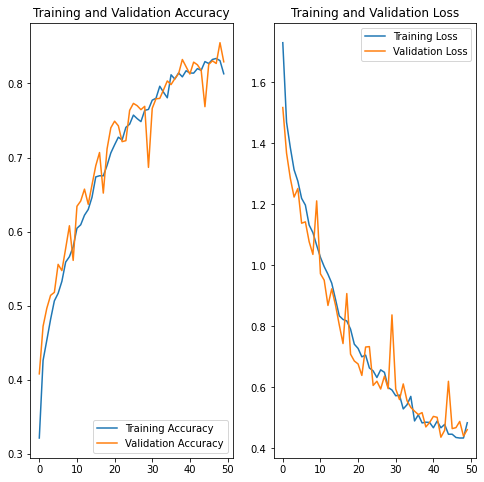

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()